In [30]:
import pandas as pd

In [39]:
a = pd.read_csv('../ImageClassification_DjangoApp/data/Metadata.csv')

In [40]:
a

,image_id,dx,date
0,ISIC_0027419,bkl,NaN
1,Apple,23,2021-06-10 09:08:51.760611


In [41]:
a = a.append({'image_id' : 'Apple' , 'dx' : 23, 'date' : pd.Timestamp.now()} , ignore_index=True)

In [44]:
a.drop_duplicates(['image_id'], keep='last')

,image_id,dx,date
0,ISIC_0027419,bkl,NaN
2,Apple,23,2021-06-10 09:12:51.398722


In [45]:
a

,image_id,dx,date
0,ISIC_0027419,bkl,NaN
1,Apple,23,2021-06-10 09:08:51.760611
2,Apple,23,2021-06-10 09:12:51.398722


In [38]:
a.to_csv('../ImageClassification_DjangoApp/data/Metadata.csv', index = False)

In [33]:
pd.Timestamp.now()

Timestamp('2021-06-10 09:08:45.388138')

In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch, torchvision
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Segmentation Model
from Model.Segmentation.ResNetUNet import ResNetUNet

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [2]:
# Parameter => Equal to Segmentation_Model
input_size = 224
norm_mean = [0.76304215, 0.5456439, 0.5700431]
norm_std = [0.14092751, 0.15261441, 0.16997588]

# Validation & Test Transform
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

In [3]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
back_alpha = 0.7

### BaseLine Model

In [4]:
# DenseNet -> Output:7
model_ft = models.densenet121(pretrained=True)
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 7)
model = model_ft.to(device)
# Load PreTrain Model
model.load_state_dict(torch.load('./PreTrainModel/base_clf_model.pt'))
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Proposed Model

In [5]:
# DenseNet -> Output:7
model_ft = models.densenet121(pretrained=True)
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 7)
pro_model = model_ft.to(device)
# Load PreTrain Model
pro_model.load_state_dict(torch.load('./PreTrainModel/'+str(back_alpha)+'_clf_model.pt'))
pro_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Segmentation Model

In [6]:
seg_model = ResNetUNet(n_class = 1).to(device)
seg_model.load_state_dict(torch.load('./PreTrainModel/seg_model.pt'))
seg_model.eval()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

### Prediction Function

In [7]:
def predict_black_picture(path, label, model, val_transform):
    soft = torch.nn.Softmax(dim=1)
    
    X = Image.open(path).convert('RGB')
    plt.imshow(X)

    X = val_transform(X)
    y = label

    out = model(X.reshape(1,3,224,224).to(device))
    probability = soft(out)
    pred = torch.argmax(probability).item()
    pred_probability = torch.max(probability).item()

    print('Original Label: {}, Prediction: {}, Probability: {:.4f}'.format(y, pred, pred_probability))

In [8]:
def predict_black_picture2(path, label, model, val_transform, seg_model, back_alpha):
    soft = torch.nn.Softmax(dim=1)
    
    X = Image.open(path).convert('RGB')
    plt.imshow(X)

    X = val_transform(X)
    y = label
    
    # Segmentation
    seg_img = seg_model(X.reshape(1,3,224,224).to(device))
    seg_img = torch.round(torch.sigmoid(seg_img))
    seg_img = torch.cat([seg_img, seg_img, seg_img], dim=1)
    seg_img[seg_img == 0] = back_alpha
    X = torch.mul(X, seg_img.cpu())
    
    out = model(X.reshape(1,3,224,224).to(device))
    probability = soft(out)
    pred = torch.argmax(probability).item()
    pred_probability = torch.max(probability).item()

    print('Original Label: {}, Prediction: {}, Probability: {:.4f}'.format(y, pred, pred_probability))

### For Train Sample

In [9]:
# Image Path
train_image_path = glob('./Dataset/Train/*.jpg')
train_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in train_image_path}

# For Label
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# MetaData
df_original = pd.read_csv(os.path.join('./Dataset', 'Metadata.csv'))
df_original['path'] = df_original['image_id'].map(train_path_dict.get)
# Select Only Train Sample
df_original = df_original[~df_original['path'].isna()]

df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./Dataset/Train/ISIC_0027419.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./Dataset/Train/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./Dataset/Train/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./Dataset/Train/ISIC_0031633.jpg,Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,./Dataset/Train/ISIC_0027850.jpg,Benign keratosis-like lesions,2


## Compare Train Sample & Black Sample

### BaseLine

Original Label: 0, Prediction: 0, Probability: 0.9949


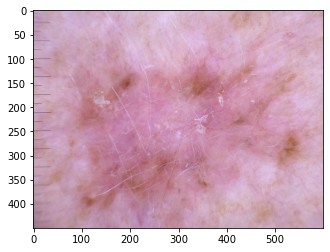

In [31]:
train_path = df_original[df_original['cell_type_idx'] == 0].iloc[2]['path']
black_path = './Black_Data/AC_0_1.png'
label = 0

predict_black_picture(train_path, label, model, val_transform)

Original Label: 0, Prediction: 2, Probability: 0.6177


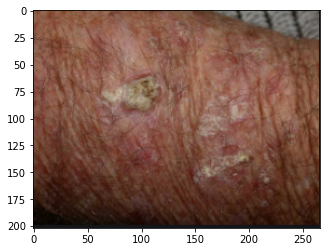

In [16]:
predict_black_picture(black_path, label, model, val_transform)

### Proposed

Original Label: 0, Prediction: 0, Probability: 0.9980


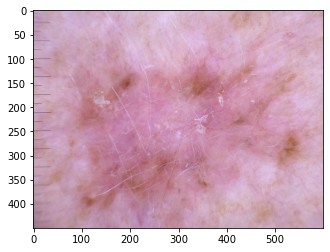

In [30]:
train_path = df_original[df_original['cell_type_idx'] == 0].iloc[2]['path']
black_path = './Black_Data/AC_0_1.png'
label = 0

predict_black_picture2(train_path, label, pro_model, val_transform, seg_model, back_alpha)

Original Label: 0, Prediction: 0, Probability: 0.7827


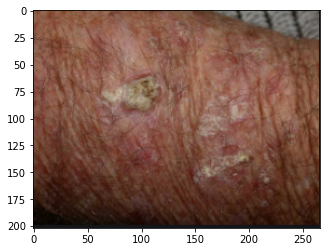

In [22]:
predict_black_picture2(black_path, label, pro_model, val_transform, seg_model, back_alpha)